In [1]:
# Import statements
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import urllib.request # to import images from dataset
import sys

from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_csv('/Users/gyeexi/Desktop/fastText/all_samples (also includes non multimodal)/all_test_public.tsv', sep='\t')

In [3]:
df = df1.filter(['score','clean_title', 'domain'],axis=1)

In [4]:
df.head()

,score,clean_title,domain
0,16,virginia first lady criticized for handing cot...,philly.com
1,7,jason falconer reluctant hero stopped mall att...,cnn.it
2,3,NaN,NaN
3,7,woman bites camels testicles to save herself a...,wbrz.com
4,3,stargazer,NaN


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [6]:
df[["score","domain"]].head(10)

,score,domain
0,16,philly.com
1,7,cnn.it
2,3,NaN
3,7,wbrz.com
4,3,NaN
5,2,self.SubredditSimulator
6,2,NaN
7,15,hollywoodreporter.com
8,1,NaN
9,1,NaN


In [7]:
df = df[df['domain'] != ''] ##removing with no headline title
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92444 entries, 0 to 92443
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   score        92444 non-null  int64 
 1   clean_title  84481 non-null  object
 2   domain       67133 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


prepare and train

Following is the dataset scheme we will use for modeling to simulate a small labeled dataset problem

Train Dataset: 70% Headlines
Test Dataset: 30% Headlines

In [8]:
from sklearn.model_selection import train_test_split

headlines = df['domain'].values
is_fake = df['score'].values


train_h, test_h, train_if, test_if = train_test_split(headlines, is_fake, test_size=0.3, random_state = 42)
train_h.shape, test_h.shape, train_if.shape, test_if.shape

((64710,), (27734,), (64710,), (27734,))

In [9]:
train_h

array(['i.reddituploads.com', nan, 'i.reddituploads.com', ..., nan,
       'nytimes.com', nan], dtype=object)

basic data processing 


In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/gyeexi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        if not isinstance(doc, str):  # Ensure doc is a string
            doc = str(doc)
        doc = doc.translate(str.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)  # Ensure this function is handling strings correctly
        norm_docs.append(doc)
    return norm_docs
    

In [12]:
norm_train_h = pre_process_corpus(train_h)
norm_test_h = pre_process_corpus(test_h)

100%|█████████████████████████████████| 27734/27734 [00:00<00:00, 449541.96it/s]


In [13]:
norm_train_h[:10]

['i.reddituploads.com',
 'nan',
 'i.reddituploads.com',
 'nan',
 'i.telegraph.co.uk',
 'nan',
 'nan',
 'nan',
 'yahoo.com',
 'i.redd.it']

In [14]:
import tensorflow as tf

2025-03-09 13:09:28.424237: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_h)
t.word_index['<PAD>'] = 0

In [16]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      t.word_index['<UNK>'])

('judicialwatch', 4079) ('<PAD>', 0) 1


In [17]:
train_sequences = t.texts_to_sequences(norm_train_h)
test_sequences = t.texts_to_sequences(norm_test_h)

In [18]:

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=4080
Number of Documents=64710


In [19]:

norm_train_h[:2]

['i.reddituploads.com', 'nan']

In [20]:
train_sequences[:2]

[[2, 15, 3], [6]]

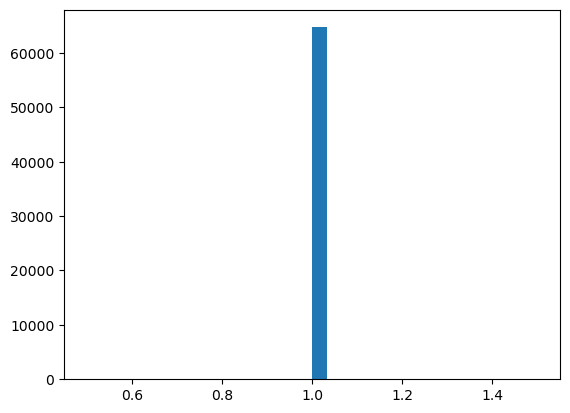

In [21]:
import matplotlib.pyplot as plt

plt.hist([len(doc.split()) for doc in norm_train_h], bins=30);

In [22]:
MAX_SEQUENCE_LENGTH = 25

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((64710, 25), (27734, 25))

In [23]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=128

In [25]:
import urllib.request

url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip"
urllib.request.urlretrieve(url, "crawl-300d-2M-subword.zip")

print("Download complete!")



KeyboardInterrupt: 

In [ ]:
import zipfile

# Define the file path
zip_file_path = "crawl-300d-2M-subword.zip"
extract_folder = "fasttext_vectors/"

# Open the zip file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Extraction complete. Files are extracted to {extract_folder}")


In [ ]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './crawl-300d-2M-subword.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx, 
                                           max_features=VOCAB_SIZE, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

In [ ]:
# create the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, train_if, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = model.predict(X_test, batch_size=2048, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print("Accuracy: %.2f%%" % (accuracy_score(test_if, predictions)*100))
print(classification_report(test_if, predictions))
pd.DataFrame(confusion_matrix(test_if, predictions))